In [6]:
#Imports
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import time
from functools import partial


In [7]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1" 

In [8]:
# def filt_as_var(filt_name, width, in_ch, out_ch):
#     """Takes in integers of 1-D filter width and num channels. 
#         Returns a variable of same width and num_channels in (width, #inp_chan, #out_chan) format"""
#     return tf.get_variable(name = filt_name, shape = [width, 1, n_ch], initializer = tf.contrib.layers.xavier_initializer(), 
#                     dtype = tf.float32)

In [55]:
def split_to_blocks(inps, block_len):
    """Takes in a (?, enc_inpt) dim matrix, and splits it into a arrays of dim (?, self.config.block_len) for all except the last array
    which is (?, n) where n = chan_enc_inp % self.config.block_len"""
    inp_len = inps.get_shape().as_list()[1]
    num_full_mats = int(np.floor(inp_len / block_len))
#     print(num_full_mats)
    dim_last_mat = int(inp_len % block_len)
#     print(dim_last_mat)
    split_inps = []
    for i in range(num_full_mats):
        new_split = tf.slice(inps, [0, block_len * i], [-1, block_len])
        split_inps.append(new_split)
    if (dim_last_mat > 0):
        split_inps.append(tf.slice(inps, [0, block_len * num_full_mats], [-1, dim_last_mat]))
    return split_inps
    
def append_blocks(self,dec_outs):
    """Appends list of decoder out tensors, then passes them through binarizer to match input length."""
    concatenated = tf.concat(dec_outs, axis=1)
#         decoded = tf.layers.dense(concatenated, self.config.chan_dec_out_len, kernel_initializer = tf.contrib.layers.xavier_initializer())
    return concatenated

In [62]:
class ChannelEncoder(object):
    def __init__(self, enc_inputs, isTrain, config):
        self.isTrain = isTrain
        self.config = config
#         self.enc_input_lst = enc_input_lst
        
        self.enc_out = []
        block_len = int(self.config.chan_enc_in_len / self.config.num_blocks)
        self.split_inps = split_to_blocks(enc_inputs, block_len) #List of split tensors 
#         print("Inputs split: ", self.split_inps)
        for ind, input_elem in enumerate(self.split_inps):
            enc_out_nonbin = self.build_chan_enc_net(ind, input_elem)
            self.enc_out.append(self.binarize(enc_out_nonbin))          
        self.enc_out = tf.concat(self.enc_out, 1)
        
    def build_chan_enc_net(self, ind, enc_input):
        
        enc_filters = self.config.enc_filters #list of dicts for enc filter dims
        num_layers = len(enc_filters)
        
        layer_outs = []
        layer_input = tf.expand_dims(enc_input, len(enc_input.shape))

        with tf.variable_scope("encoder", reuse = tf.AUTO_REUSE):
            
            for l, layer_dims in enumerate(enc_filters): #iterate over encoder layers 
                n_ch = layer_dims["n_ch"]
                filt_sz = layer_dims["filt_sz"]
                strides = layer_dims["strides"]
                #With pooling
    #             pool_size = layer_dims["pool_size"]
    #             pool_strides = layer_dims["pool_strides"]

                num_parallels = len(filt_sz)

                parallels = []
                for p in range(num_parallels): #iterate over parallels
                    filt_name = "enc"+"L"+str(l+1)+"P"+str(p+1)
                    n_chan_prev = 1 
                    filt_var1 = tf.get_variable(name = filt_name, shape = [filt_sz[p], n_chan_prev, n_ch[p]], initializer = tf.contrib.layers.xavier_initializer(), 
                        dtype = tf.float32)
                    Z1 = tf.nn.conv1d(layer_input, filt_var1, strides[p], 'SAME')
                    A1 = tf.nn.relu(Z1)
    #                 P = tf.layers.max_pooling1d(A, pool_size[p], pool_strides[p], padding = "SAME")
    #                 filt_var2 = tf.get_variable(name = filt_name + "2", shape = [filt_sz[p], int(n_ch[p] / 3), int(2 * n_ch[p]/3)], initializer = tf.contrib.layers.xavier_initializer(), 
    #                     dtype = tf.float32)
    #                 Z2 = tf.nn.conv1d(A1, filt_var2, strides[p], 'SAME')
    #                 A2 = tf.nn.relu(Z2)
    #                 filt_var3 = tf.get_variable(name = filt_name + "3", shape = [filt_sz[p], int(2 * n_ch[p] / 3), n_ch[p]], initializer = tf.contrib.layers.xavier_initializer(), 
    #                     dtype = tf.float32)
    #                 Z3 = tf.nn.conv1d(A2, filt_var3, strides[p], 'SAME')
    #                 A3 = tf.nn.relu(Z3)
                    P = A1
                    F = tf.contrib.layers.flatten(P)
                    parallels.append(F)
                concatenated = tf.concat(parallels, axis=1)
                print(concatenated)
                layer_outs.append(concatenated)
                layer_input = tf.expand_dims(layer_outs[-1], len(layer_outs[-1].shape))

    #         print(layer_outs[-1])

            fc_acts = []
            fc_acts.append(layer_outs[-1])

            for fc in range(len(self.config.enc_FCs) - 1):
                fc = tf.contrib.layers.fully_connected(fc_acts[-1], int(self.config.enc_FCs[fc] / 10), activation_fn = tf.nn.relu, )
                fc_acts.append(fc)

            fc_out = tf.layers.dense(fc_acts[-1], int(self.config.enc_FCs[-1] / 10), activation = tf.tanh)
        
        return tf.expand_dims(fc_out, len(fc_out.shape)) #Expand dims to fit conv across channel
    
    def training_binarizer(self, input_layer):
        """Binarizer function used at training
        """
        prob = tf.truediv(tf.add(1.0, input_layer), 2.0)
        bernoulli = tf.contrib.distributions.Bernoulli(probs=prob, dtype=tf.float32)
        return 2 * bernoulli.sample() - 1

    def test_binarizer(self, input_layer):
        """Binarizer function used during testing
        """
        ones = tf.ones_like(input_layer,dtype=tf.float32)
        neg_ones = tf.scalar_mul(-1.0, ones)
        return tf.where(tf.less(input_layer,0.0), neg_ones, ones)

    def binarize(self, reduced_states):
        binarized = tf.cond(self.isTrain,
                            partial(self.training_binarizer, reduced_states),
                            partial(self.test_binarizer, reduced_states))

        pass_through = tf.identity(reduced_states) # this is used for pass through gradient back prop
        return pass_through + tf.stop_gradient(binarized - pass_through)




In [57]:
class ISI_Channel(object):
    def __init__(self, enc_out,  config, noise = True, dynamic_channel = False):
        self.config = config
        self.chan_param = config.channel["chan_param"]
        self.type = config.channel["type"]
        self.chan_in = enc_out
        self.filter = self.get_filter(self.chan_param["ISI_distrib"]) #returns 3D tensor
        self.chan_out = self.build_channel()
#         print(self.chan_out)
        if noise == True:
            self.chan_out = self.gaussian_noise_layer(self.chan_out, self.chan_param["noise_std"])
                
    def build_channel(self):
        if (self.type == "ISI"):
            
            chan_out = tf.nn.conv1d(self.chan_in, self.filter, self.chan_param["stride"], 'SAME', name = "chan_ISI")
            
        return chan_out 
        
    def get_filter(self, distrib = "rayleigh"):
        if distrib == "rayleigh":
            sf = self.chan_param["distrib_param"]
            chan_filt_dims = (self.chan_param["chan_filt_width"], 1, 1) # (width, num_in_chan, num_out_chan)
            filt_vals = np.random.rayleigh(scale = sf, size = chan_filt_dims)
            
        return tf.convert_to_tensor(filt_vals, dtype = tf.float32)
        
    def gaussian_noise_layer(self, input_layer, std, name=None):
#         print(input_layer)
        noise = tf.random_normal(shape=tf.shape(input_layer), mean=0.0,
                                 stddev=std, dtype=tf.float32, name="chan_noise")
        return input_layer + noise

In [96]:
class ChannelDecoder(object):
    def __init__(self, chan_out, isTrain, config):
        self.isTrain = isTrain
        self.config = config
        self.dec_input = chan_out
#         self.dec_out = self.build_chan_dec_net()
#         self.dec_labels = tf.where(tf.less(self.dec_out,0.0), 
#                                  -1 * tf.ones_like(self.dec_out,dtype=tf.float32), 
#                                  tf.ones_like(self.dec_out,dtype=tf.float32))
        self.dec_outs = []
        chan_out = tf.squeeze(chan_out, [2])
        print("channel_out:", chan_out)
        dec_block_len = int(chan_out.get_shape().as_list()[1] / self.config.num_blocks)
        split_chan_outs = split_to_blocks(chan_out, dec_block_len)
        for ind, chan_out_elem in enumerate(split_chan_outs):
            self.dec_outs.append(self.build_chan_dec_net(chan_out_elem, ind))
            
        self.dec_out = tf.concat(self.dec_outs, 1)
        print(self.dec_out)
#         self.decoded = tf.layers.dense()
        fc_1 = tf.contrib.layers.fully_connected(self.dec_out, 1024, activation_fn = tf.nn.relu)
        fc_2 = tf.contrib.layers.fully_connected(fc_1, 400, activation_fn = None)
#         fc_3 = tf.contrib.layers.fully_connected(fc_2, 400, activation_fn = None)

        self.decoded = fc_2
        
    def build_chan_dec_net(self, chan_out, ind):
        
        dec_filters = self.config.dec_filters #list of dicts for enc filter dims
        num_layers = len(dec_filters)
        
        layer_outs = []
        layer_input = tf.expand_dims(chan_out, len(chan_out.shape))
        with tf.variable_scope("decoder", reuse = tf.AUTO_REUSE):
            for l, layer_dims in enumerate(dec_filters): #iterate over decoder layers 
                n_ch = layer_dims["n_ch"]
                filt_sz = layer_dims["filt_sz"]
                strides = layer_dims["strides"]

                #With pooling
    #             pool_size = layer_dims["pool_size"]
    #             pool_strides = layer_dims["pool_strides"]

                num_parallels = len(filt_sz)

                parallels = []
                for p in range(num_parallels): #iterate over parallels
                    filt_name = "dec"+"L"+str(l+1)+"P"+str(p+1)
                    n_chan_prev = 1 
                    filt_var1 = tf.get_variable(name = filt_name, shape = [filt_sz[p], n_chan_prev, n_ch[p]], initializer = tf.contrib.layers.xavier_initializer(), 
                        dtype = tf.float32)
                    Z1 = tf.nn.conv1d(layer_input, filt_var1, strides[p], 'SAME')
                    A1 = tf.nn.relu(Z1)
    # #                 P = tf.layers.max_pooling1d(A, pool_size[p], pool_strides[p], padding = "SAME")
    #                 filt_var2 = tf.get_variable(name = filt_name + "2", shape = [filt_sz[p], int(n_ch[p] / 3), int(2 * n_ch[p]/3)], initializer = tf.contrib.layers.xavier_initializer(), 
    #                     dtype = tf.float32)
    #                 Z2 = tf.nn.conv1d(A1, filt_var2, strides[p], 'SAME')
    #                 A2 = tf.nn.relu(Z2)
    #                 filt_var3 = tf.get_variable(name = filt_name + "3", shape = [filt_sz[p], int(2 * n_ch[p] / 3), n_ch[p]], initializer = tf.contrib.layers.xavier_initializer(), 
    #                     dtype = tf.float32)
    #                 Z3 = tf.nn.conv1d(A2, filt_var3, strides[p], 'SAME')
    #                 A3 = tf.nn.relu(Z3)
    #                 P = A3
                    F = tf.contrib.layers.flatten(A1)
                    parallels.append(F)
                concatenated = tf.concat(parallels, axis=1)
                print(concatenated)
                layer_outs.append(concatenated)
                layer_input = tf.expand_dims(layer_outs[-1], len(layer_outs[-1].shape))

            fc_acts = []
            fc_acts.append(layer_outs[-1])

            for fc in range(len(self.config.dec_FCs) - 1):
                fc = tf.contrib.layers.fully_connected(fc_acts[-1], self.config.dec_FCs[-1] , activation_fn = tf.nn.relu)
                fc_acts.append(fc)

            fc_out = tf.contrib.layers.fully_connected(fc_acts[-1], self.config.dec_FCs[-1], activation_fn = tf.tanh)

        return fc_out

In [97]:
class ChannelSystem():
    def __init__(self, config):
        self.config = config
        
        #self.learn_rate = tf.placeholder(tf.float32,shape=(), name='learn_rate')
        self.lr = tf.placeholder(tf.float32, shape = [], name = 'lr')
        self.X = tf.placeholder(tf.float32, shape = [None, self.config.chan_enc_in_len], name = 'dataset_iter_X')
        self.Y = tf.placeholder(tf.float32, shape = [None, self.config.chan_dec_out_len], name = 'dataset_iter_Y')
#         print("X:", self.X) 
        self.isTrain = tf.placeholder(tf.bool,shape=(), name='isTrain')
#         self.chan_enc_inputs = tf.placeholder(tf.float32, shape = [None, self.config.chan_enc_in_len], name = 'enc_inputs')
#         self.dec_targets = tf.placeholder(tf.float32, shape = [None, self.config.chan_dec_out_len], name = 'dec_targets')
            
        self.dataset = tf.data.Dataset.from_tensor_slices((self.X, self.Y)).shuffle(buffer_size=100).batch(config.batch_size).repeat()
        
        self.iterator = self.dataset.make_initializable_iterator()
        
        self.chan_enc_inputs, self.dec_targets = self.iterator.get_next()
        #Build channel coder
        print("Chan enc inputs: ", self.chan_enc_inputs)
        
        self.channel_encoder = ChannelEncoder(self.chan_enc_inputs, self.isTrain, config)
        print("Channel input: ", self.channel_encoder.enc_out) 
        self.channel = ISI_Channel(self.channel_encoder.enc_out, config, noise = True)
        print("Channel output: ", self.channel.chan_out) 
        self.channel_decoder = ChannelDecoder(self.channel.chan_out, self.isTrain, config)
        print("Dec out: ", self.channel_decoder.dec_out) 
        self.dec_labels = self.get_labels(self.channel_decoder.decoded) 
        self.accuracy = self.define_accuracy()
        self.loss, self.train_op = self.define_loss()
        
        
    def get_labels(self, reals):
        return tf.where(tf.less(reals,0.0), 
                                 -1 * tf.ones_like(reals,dtype=tf.float32), 
                                 tf.ones_like(reals,dtype=tf.float32))
    
    """
    Script to generate train and test data
    """
    def gen_bin_data(self, num_samples, sample_len, seed_num = None):
        
        if (seed_num != None):
            np.random.seed(seed_num)
        randMat = np.random.rand(num_samples, sample_len)
        binMat = np.where(randMat > 0.5, 1.0, -1.0)
        return binMat
    
    def define_accuracy(self):
        eq_indicator = tf.cast(tf.equal(self.dec_labels, self.dec_targets), dtype=tf.float32)
        return tf.reduce_mean(eq_indicator)

    def define_loss(self):
        adapted_targets = tf.cast(self.dec_targets > 0, tf.float32)
        loss = tf.losses.hinge_loss(adapted_targets, self.channel_decoder.decoded)

        train_op = tf.train.AdamOptimizer(learning_rate=self.lr).minimize(loss) 
        return loss, train_op
    
    def train(self, sess):
        params = tf.trainable_variables()
        num_params = sum(
            map(lambda t: np.prod(tf.shape(t.value()).eval()), params))
        print('Total model parameters: ', num_params)
        self.training_counter = 0
        accuracies = []
        try:
            tic = time.time() 
            curr_lr = self.config.init_lr
            for epoch in range(self.config.n_epochs):
            
                # =============================  Train on Training Data ===============================
                train_data = self.gen_bin_data(self.config.train_size, self.config.chan_enc_in_len)
                sess.run(self.iterator.initializer, feed_dict = {self.X: train_data, self.Y: train_data})
                if (epoch > 0): curr_lr = curr_lr / np.sqrt(epoch)
                train_fd = {self.isTrain: True, self.lr : curr_lr}

                for i in range(self.config.batch_per_epoch):
                    
#                     _, loss, channel_filt_1 = sess.run([self.train_op, self.loss, self.channel.filter], feed_dict = train_fd)
#                     channel_filt_2 = sess.run(self.channel.filter)
#                     print(channel_filt_1, channel_filt_2)
                    loss, _, optimizer_lr = sess.run([self.loss, self.train_op, self.lr], train_fd)
                    self.training_counter += 1
#                     print(sess.run(self.channel.filter, train_fd))
                    if self.training_counter % self.config.print_every == 0:
                        toc = time.time()

                        acc = sess.run(self.accuracy, train_fd)

                        print("Epoch: ", epoch + 1, 
                              "Accuracy: ", acc,
                              "Training iteration: ", self.training_counter,
                              "Training time: ", int(toc-tic), "s",
                              "Training loss: ", loss,
                              "Learning rate", optimizer_lr)
                        accuracies.append(acc)

#                     if self.training_counter % self.config.save_every == 0:
#                         self.saver.save(sess, self.config.model_save_path, global_step=self.training_counter // self.config.save_every)
#                         print("Model saved in file: %s" % self.config.model_save_path)


#                 # =========================== Save the Model ==========================================
#                 self.saver.save(sess, self.config.model_save_path, global_step=i)
#                 print("Model saved in file: %s" % self.config.model_save_path)

        except KeyboardInterrupt:
            print('training interrupted')
        #Save model, plot accuracies    
#         self.saver.save(sess, self.config.model_save_path, global_step=self.training_counter)
#         print("Model saved in file: %s" % self.config.model_save_path) 
        
        return accuracies
    
    def test(self, sess):
        
        test_data = self.gen_bin_data(self.config.test_size, self.config.chan_enc_in_len)
        
        #sess.run(self.iterator.initializer, feed_dict = {self.X: test_data, self.Y: test_data})
        print("Testing...")
        test_fd = {self.isTrain : False}
        
        self.chan_enc_inputs, self.dec_targets = (test_data, test_data)
        
        test_acc = sess.run(self.accuracy, feed_dict = test_fd) 
        test_loss = sess.run(self.loss, feed_dict = test_fd)
#         print(sess.run(self.channel_encoder.enc_out, test_fd))
        print("Test loss: ", test_loss, "\nTest accuracy: ", test_acc)

        return test_acc
        

In [60]:
class Config(object):
    """The model configuration
    """

    def __init__(self, 
                 enc_filters,
                 dec_filters,
                 numb_tx_bits, 
                 chan_enc_in_len,
                 channel,
                 enc_FCs,
                 dec_FCs,
                 n_epochs = 10, 
                 init_lr = 0.001,
                 batch_size = 100,
                 dropout = True,
                 train_size = int(1e5),
                 test_size = 1000,
                 print_every = 100,
                 batch_per_epoch = int(1e4)):
        self.enc_filters, self.dec_filters = (enc_filters, dec_filters)
        self.channel = channel
        self.chan_enc_in_len = chan_enc_in_len
        self.chan_dec_out_len = self.chan_enc_in_len
        self.numb_tx_bits = numb_tx_bits
        self.n_epochs = n_epochs
        self.init_lr = init_lr
        self.dropout = dropout
        self.train_size = train_size #Size of train set per epoch
        self.test_size = test_size #Size of test set per epoch
        self.batch_size = batch_size
        self.print_every = print_every
        self.batch_per_epoch = batch_per_epoch
        self.enc_FCs = enc_FCs
        self.dec_FCs = dec_FCs
        self.chan_width = 3
#         self.block_len = 40
        self.num_blocks = 10

{'enc_filters': [{'filt_sz': [16, 32, 8, 4, 16], 'n_ch': [32, 32, 32, 32, 32], 'strides': [2, 16, 4, 4, 8]}], 'dec_filters': [{'filt_sz': [16, 32, 8, 4, 16], 'n_ch': [32, 32, 32, 32, 32], 'strides': [4, 16, 4, 1, 8]}], 'channel': {'type': 'ISI', 'chan_param': {'ISI_distrib': 'rayleigh', 'chan_filt_width': 3, 'stride': 1, 'distrib_param': 1, 'noise_std': 1}}, 'chan_enc_in_len': 400, 'chan_dec_out_len': 400, 'numb_tx_bits': 600, 'n_epochs': 20, 'init_lr': 0.001, 'dropout': True, 'train_size': 100000, 'test_size': 1000000, 'batch_size': 100, 'print_every': 1000.0, 'batch_per_epoch': 1000, 'enc_FCs': [512, 600], 'dec_FCs': [1024, 256, 40], 'chan_width': 3, 'num_blocks': 10}
Chan enc inputs:  Tensor("IteratorGetNext:0", shape=(?, 400), dtype=float32)
Tensor("encoder/concat:0", shape=(?, 1536), dtype=float32)
Tensor("encoder_1/concat:0", shape=(?, 1536), dtype=float32)
Tensor("encoder_2/concat:0", shape=(?, 1536), dtype=float32)
Tensor("encoder_3/concat:0", shape=(?, 1536), dtype=float32)
Te

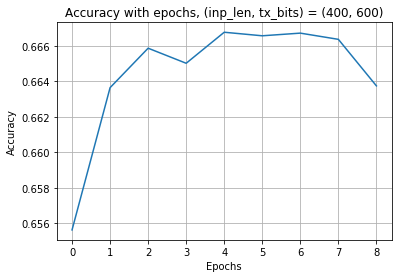

In [99]:
#=================================================Main================================================================
tf.reset_default_graph()

#channel specs
chan_type = "ISI"
chan_param = {"ISI_distrib": "rayleigh",
              "chan_filt_width":3, 
              "stride": 1,
              "distrib_param": 1,
              "noise_std": 1}
channel = {"type": chan_type, "chan_param": chan_param}

#Enc and dec filter specs
enc_L1 = {"filt_sz": [16, 32, 8, 4, 16], "n_ch":[32, 32, 32, 32, 32], "strides":[2, 16, 4, 4, 8]}

dec_L1 = {"filt_sz": [16, 32, 8, 4, 16], "n_ch":[32, 32, 32, 32, 32], "strides":[4, 16, 4, 1, 8]}

#List of attributes for each layer. The keys within a layer map to attributes for PARALLEL filters
# enc_filters = [enc_L1, enc_L2] 
enc_filters = [enc_L1] 
dec_filters = [dec_L1]

#bit vector dims
chan_enc_in_len = 400
numb_tx_bits = 600

#Dimensions of FC layers. All have RELU acts, except last layer of enc(tanh) and dec(None) 
enc_FCs = [512, numb_tx_bits]
# dec_FCs = [4096, 1024, chan_enc_in_len]
dec_FCs = [1024, 256, 40]

sys_config = Config(enc_filters, dec_filters, numb_tx_bits, chan_enc_in_len, channel, enc_FCs, dec_FCs,
                   n_epochs = 20, batch_size = 100, batch_per_epoch= int(1e3), train_size = int(1e5), test_size = int(1e6),
                   print_every = 1e3, init_lr = 0.001)

print(vars(sys_config))
channel_system = ChannelSystem(sys_config)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    train_accs = channel_system.train(sess) #params are weights of encoder and decoder conv layers
    test_accs = channel_system.test(sess) 
      
plt.plot(train_accs)
plt.title("Accuracy with epochs, (inp_len, tx_bits) = ({}, {})".format(str(chan_enc_in_len), str(numb_tx_bits)))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)  

In [32]:
print([var for var in tf.trainable_variables()])
# print(vars(sys_config))

# enc_L1["pool_size"] = [4, 4, 4, 4]
# enc_L1["pool_strides"] = [4, 4, 4, 4]
# enc_L2["pool_size"] = [4,4,4]
# enc_L2["pool_strides"] = [4,4,4]

# dec_L1["pool_size"] = enc_L1["pool_size"]
# dec_L1["pool_strides"]= enc_L1["pool_strides"]
# dec_L2["pool_size"] = enc_L2["pool_size"]
# dec_L2["pool_strides"]= enc_L2["pool_strides"]


[<tf.Variable 'encoder/encL1P1:0' shape=(16, 1, 32) dtype=float32_ref>, <tf.Variable 'encoder/encL1P2:0' shape=(32, 1, 32) dtype=float32_ref>, <tf.Variable 'encoder/encL1P3:0' shape=(8, 1, 32) dtype=float32_ref>, <tf.Variable 'encoder/encL1P4:0' shape=(4, 1, 32) dtype=float32_ref>, <tf.Variable 'encoder/encL1P5:0' shape=(16, 1, 32) dtype=float32_ref>, <tf.Variable 'encoder/fully_connected/weights:0' shape=(1536, 512) dtype=float32_ref>, <tf.Variable 'encoder/fully_connected/biases:0' shape=(512,) dtype=float32_ref>, <tf.Variable 'encoder/dense/kernel:0' shape=(512, 450) dtype=float32_ref>, <tf.Variable 'encoder/dense/bias:0' shape=(450,) dtype=float32_ref>]


In [ ]:
# #Original 
# class ChannelEncoder(object):
#     def __init__(self, enc_input, isTrain, config):
#         self.isTrain = isTrain
#         self.config = config
#         self.enc_input = enc_input
#         self.enc_out_nonbin = self.build_chan_enc_net()
#         self.enc_out = self.binarize(self.enc_out_nonbin)
#     def build_chan_enc_net(self):
        
#         enc_filters = self.config.enc_filters #list of dicts for enc filter dims
#         num_layers = len(enc_filters)
        
#         layer_outs = []
#         layer_input = self.enc_input
#         layer_input = tf.expand_dims(self.enc_input, len(self.enc_input.shape))

#         for l, layer_dims in enumerate(enc_filters): #iterate over encoder layers 
#             n_ch = layer_dims["n_ch"]
#             filt_sz = layer_dims["filt_sz"]
#             strides = layer_dims["strides"]
#             #With pooling
# #             pool_size = layer_dims["pool_size"]
# #             pool_strides = layer_dims["pool_strides"]
            
#             num_parallels = len(filt_sz)
            
#             parallels = []
#             for p in range(num_parallels): #iterate over parallels
#                 filt_name = "enc"+"L"+str(l+1)+"P"+str(p+1)
#                 n_chan_prev = 1 
#                 filt_var = tf.get_variable(name = filt_name, shape = [filt_sz[p], n_chan_prev, n_ch[p]], initializer = tf.contrib.layers.xavier_initializer(), 
#                     dtype = tf.float32)
#                 Z = tf.nn.conv1d(layer_input, filt_var, strides[p], 'SAME')
#                 A = tf.nn.relu(Z)
#                 #P1 = tf.nn.max_pool(A1, ksize = [1, poolSz[0], poolSz[0], 1], strides = [1, poolSz[0], poolSz[0], 1], padding = "SAME")
# #                 P = tf.layers.max_pooling1d(A, pool_size[p], pool_strides[p], padding = "SAME")
#                 P = A
#                 F = tf.contrib.layers.flatten(P)
#                 parallels.append(F)
#             concatenated = tf.concat(parallels, axis=1)
#             print(concatenated)
#             layer_outs.append(concatenated)
#             layer_input = tf.expand_dims(layer_outs[-1], len(layer_outs[-1].shape))
        
# #         print(layer_outs[-1])
        
#         fc_acts = []
#         fc_acts.append(layer_outs[-1])
        
#         for fc in range(len(self.config.enc_FCs) - 1):
#             fc = tf.contrib.layers.fully_connected(fc_acts[-1], self.config.enc_FCs[fc], activation_fn = tf.nn.relu)
#             fc_acts.append(fc)
        
#         fc_out = tf.contrib.layers.fully_connected(fc_acts[-1], self.config.enc_FCs[-1], activation_fn = tf.tanh)
        
#         return tf.expand_dims(fc_out, len(fc_out.shape)) #Expand dims to fit conv across channel
    
#     def training_binarizer(self, input_layer):
#         """Binarizer function used at training
#         """
#         prob = tf.truediv(tf.add(1.0, input_layer), 2.0)
#         bernoulli = tf.contrib.distributions.Bernoulli(probs=prob, dtype=tf.float32)
#         return 2 * bernoulli.sample() - 1

#     def test_binarizer(self, input_layer):
#         """Binarizer function used during testing
#         """
#         ones = tf.ones_like(input_layer,dtype=tf.float32)
#         neg_ones = tf.scalar_mul(-1.0, ones)
#         return tf.where(tf.less(input_layer,0.0), neg_ones, ones)

#     def binarize(self, reduced_states):
#         binarized = tf.cond(self.isTrain,
#                             partial(self.training_binarizer, reduced_states),
#                             partial(self.test_binarizer, reduced_states))

#         pass_through = tf.identity(reduced_states) # this is used for pass through gradient back prop
#         return pass_through + tf.stop_gradient(binarized - pass_through)




In [ ]:
##Original
# class ChannelDecoder(object):
#     def __init__(self, chan_out, isTrain, config):
#         self.isTrain = isTrain
#         self.config = config
#         self.dec_input = chan_out
#         self.dec_out = self.build_chan_dec_net()
#         self.dec_labels = tf.where(tf.less(self.dec_out,0.0), 
#                                  -1 * tf.ones_like(self.dec_out,dtype=tf.float32), 
#                                  tf.ones_like(self.dec_out,dtype=tf.float32))
    
#     def build_chan_dec_net(self):
        
#         dec_filters = self.config.dec_filters #list of dicts for enc filter dims
#         num_layers = len(dec_filters)
        
#         layer_outs = []
#         layer_input = self.dec_input
#         for l, layer_dims in enumerate(dec_filters): #iterate over encoder layers 
#             n_ch = layer_dims["n_ch"]
#             filt_sz = layer_dims["filt_sz"]
#             strides = layer_dims["strides"]
            
#             #With pooling
# #             pool_size = layer_dims["pool_size"]
# #             pool_strides = layer_dims["pool_strides"]
            
#             num_parallels = len(filt_sz)
            
#             parallels = []
#             for p in range(num_parallels): #iterate over parallels
#                 filt_name = "dec"+"L"+str(l+1)+"P"+str(p+1)
#                 n_chan_prev = 1 
#                 filt_var = tf.get_variable(name = filt_name, shape = [filt_sz[p], n_chan_prev, n_ch[p]], initializer = tf.contrib.layers.xavier_initializer(), 
#                     dtype = tf.float32)
#                 Z = tf.nn.conv1d(layer_input, filt_var, strides[p], 'SAME')
#                 A = tf.nn.relu(Z)
# #                 P = tf.layers.max_pooling1d(A, pool_size[p], pool_strides[p], padding = "SAME")
                
#                 P = A
#                 F = tf.contrib.layers.flatten(P)
#                 parallels.append(F)
#             concatenated = tf.concat(parallels, axis=1)
#             print(concatenated)
#             layer_outs.append(concatenated)
#             layer_input = tf.expand_dims(layer_outs[-1], len(layer_outs[-1].shape))
      
#         fc_acts = []
#         fc_acts.append(layer_outs[-1])
        
#         for fc in range(len(self.config.dec_FCs) - 1):
#             fc = tf.contrib.layers.fully_connected(fc_acts[-1], self.config.dec_FCs[fc], activation_fn = tf.nn.relu)
#             fc_acts.append(fc)
        
#         fc_out = tf.contrib.layers.fully_connected(fc_acts[-1], self.config.dec_FCs[-1], activation_fn = None)
    
#         return fc_out

In [ ]:
##Original 
# class ChannelSystem():
#     def __init__(self, config):
#         self.config = config
        
#         #self.learn_rate = tf.placeholder(tf.float32,shape=(), name='learn_rate')
#         self.lr = tf.placeholder(tf.float32, shape = [], name = 'lr')
#         self.X = tf.placeholder(tf.float32, shape = [None, self.config.chan_enc_in_len], name = 'dataset_iter_X')
#         self.Y = tf.placeholder(tf.float32, shape = [None, self.config.chan_dec_out_len], name = 'dataset_iter_Y')
# #         print("X:", self.X) 
#         self.isTrain = tf.placeholder(tf.bool,shape=(), name='isTrain')
# #         self.chan_enc_inputs = tf.placeholder(tf.float32, shape = [None, self.config.chan_enc_in_len], name = 'enc_inputs')
# #         self.dec_targets = tf.placeholder(tf.float32, shape = [None, self.config.chan_dec_out_len], name = 'dec_targets')
            
#         self.dataset = tf.data.Dataset.from_tensor_slices((self.X, self.Y)).shuffle(buffer_size=100).batch(config.batch_size).repeat()
        
#         self.iterator = self.dataset.make_initializable_iterator()
        
#         self.chan_enc_inputs, self.dec_targets = self.iterator.get_next()
#         #Build channel coder
#         print("Chan enc inputs: ", self.chan_enc_inputs)
#         self.channel_encoder = ChannelEncoder(self.chan_enc_inputs, self.isTrain, config)
#         print("Channel input: ", self.channel_encoder.enc_out)
#         self.channel = ISI_Channel(self.channel_encoder.enc_out, config, noise = True)
#         print("Channel output: ", self.channel.chan_out)
#         self.channel_decoder = ChannelDecoder(self.channel.chan_out, self.isTrain, config)
#         print("Dec out: ", self.channel_decoder.dec_out)
#         self.dec_labels = self.channel_decoder.dec_labels
#         self.accuracy = self.define_accuracy()
#         self.loss, self.train_op = self.define_loss()
        
        
    
#     """
#     Script to generate train and test data
#     """
#     def gen_bin_data(self, num_samples, sample_len, seed_num = None):
        
#         if (seed_num != None):
#             np.random.seed(seed_num)
#         randMat = np.random.rand(num_samples, sample_len)
#         binMat = np.where(randMat > 0.5, 1.0, -1.0)
#         return binMat
    
#     def define_accuracy(self):
#         eq_indicator = tf.cast(tf.equal(self.dec_labels, self.dec_targets), dtype=tf.float32)
#         return tf.reduce_mean(eq_indicator)

#     def define_loss(self):
#         adapted_targets = tf.cast(self.dec_targets > 0, tf.float32)
#         loss = tf.losses.hinge_loss(adapted_targets, self.channel_decoder.dec_out)

#         train_op = tf.train.AdamOptimizer(learning_rate=self.lr).minimize(loss) 
#         return loss, train_op
    
#     def train(self, sess):
        
#         params = tf.trainable_variables()
#         num_params = sum(
#             map(lambda t: np.prod(tf.shape(t.value()).eval()), params))
#         print('Total model parameters: ', num_params)
#         self.training_counter = 0
#         accuracies = []
#         try:
#             tic = time.time() 
#             curr_lr = self.config.init_lr
#             for epoch in range(self.config.n_epochs):
            
#                 # =============================  Train on Training Data ===============================
#                 train_data = self.gen_bin_data(self.config.train_size, self.config.chan_enc_in_len)
#                 sess.run(self.iterator.initializer, feed_dict = {self.X: train_data, self.Y: train_data})
#                 if (epoch > 0): curr_lr = curr_lr / np.sqrt(epoch)
#                 train_fd = {self.isTrain: True, self.lr : curr_lr}
                
#                 for i in range(self.config.batch_per_epoch):
                    
# #                     _, loss, channel_filt_1 = sess.run([self.train_op, self.loss, self.channel.filter], feed_dict = train_fd)
# #                     channel_filt_2 = sess.run(self.channel.filter)
# #                     print(channel_filt_1, channel_filt_2)
#                     loss, _, optimizer_lr = sess.run([self.loss, self.train_op, self.lr], train_fd)
#                     self.training_counter += 1
# #                     print(sess.run(self.channel.filter, train_fd))
#                     if self.training_counter % self.config.print_every == 0:
#                         toc = time.time()

#                         acc = sess.run(self.accuracy, train_fd)

#                         print("Epoch: ", epoch + 1, 
#                               "Accuracy: ", acc,
#                               "Training iteration: ", self.training_counter,
#                               "Training time: ", int(toc-tic), "s",
#                               "Training loss: ", loss,
#                               "Learning rate", optimizer_lr)
#                         accuracies.append(acc)

# #                     if self.training_counter % self.config.save_every == 0:
# #                         self.saver.save(sess, self.config.model_save_path, global_step=self.training_counter // self.config.save_every)
# #                         print("Model saved in file: %s" % self.config.model_save_path)


# #                 # =========================== Save the Model ==========================================
# #                 self.saver.save(sess, self.config.model_save_path, global_step=i)
# #                 print("Model saved in file: %s" % self.config.model_save_path)

#         except KeyboardInterrupt:
#             print('training interrupted')
#         #Save model, plot accuracies    
# #         self.saver.save(sess, self.config.model_save_path, global_step=self.training_counter)
# #         print("Model saved in file: %s" % self.config.model_save_path) 
        
#         return accuracies
    
#     def test(self, sess):
        
#         test_data = self.gen_bin_data(self.config.test_size, self.config.chan_enc_in_len)
        
#         #sess.run(self.iterator.initializer, feed_dict = {self.X: test_data, self.Y: test_data})
#         print("Testing...")
#         test_fd = {self.isTrain : False}
        
#         self.chan_enc_inputs, self.dec_targets = (test_data, test_data)
        
#         test_acc = sess.run(self.accuracy, feed_dict = test_fd) 
#         test_loss = sess.run(self.loss, feed_dict = test_fd)
# #         print(sess.run(self.channel_encoder.enc_out, test_fd))
#         print("Test loss: ", test_loss, "\nTest accuracy: ", test_acc)

#         return test_acc
        